# 权重衰减

## 高维线性回归实验

y=0.05+E0.01xi+c

In [38]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys

In [39]:
n_train,n_test,num_inputs=20,100,200
true_w,true_b=torch.ones(num_inputs,1)*0.01,0.05

features=torch.randn((n_train+n_test,num_inputs))
labels=torch.matmul(features,true_w)+true_b
labels+=torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float)

train_features,test_features=features[:n_train,:],features[n_train:,:]
train_labels,test_labels=labels[:n_train],labels[n_train:]

## 从零开始实现

### 初始化模型参数

In [40]:
def init_params():
    w=torch.randn((num_inputs,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return [w,b]

### 定义L2范数惩罚项

In [41]:
def l2_penalty(w):
    return (w**2).sum()/2

### 定义模型

In [42]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b

### 定义损失函数

In [43]:
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size()))**2 /2

### 定义优化函数

In [44]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data-=lr*param.grad/batch_size

### 显示损失函数图像

In [45]:
def semilogy(x_vals,y_vals,x_label,y_label,x2_vals=None,y2_vals=None,legend=None):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals,y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals,y2_vals,linestyle=':')
        plt.legend(legend)


### 定义训练和测试

In [46]:
batch_size,num_epochs,lr=1,100,0.003
net,loss=linreg,squared_loss

dataset=torch.utils.data.TensorDataset(train_features,train_labels)
train_iter=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)

def fit_and_plot(lambd):
    w,b=init_params()
    train_ls,test_ls=[],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l=loss(net(X,w,b),y)+lambd*l2_penalty(w)
            l=l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            sgd([w,b],lr,batch_size)
        train_ls.append(loss(net(train_features,w,b),train_labels).mean().item())
        test_ls.append(loss(net(test_features,w,b),test_labels).mean().item())
    semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',range(1,num_epochs+1),test_ls,['train','test'])
    print('L2 norm of w:',w.norm().item())

### 观察过拟合

L2 norm of w: 13.941560745239258


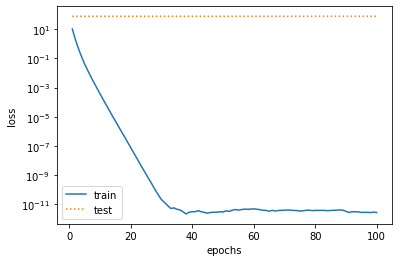

In [47]:
fit_and_plot(0)

### 使用权重衰减

L2 norm of w: 0.036008432507514954


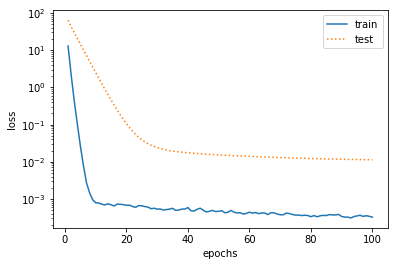

In [48]:
fit_and_plot(lambd=3)

## 简洁实现

In [49]:
def fit_and_plot_pytorch(wd):
    net=nn.Linear(num_inputs,1)
    nn.init.normal_(net.weight,mean=0,std=1)
    nn.init.normal_(net.bias,mean=0,std=1)
    optimizer_w=torch.optim.SGD(params=[net.weight],lr=lr,weight_decay=wd)#对权重参数衰减
    optimizer_b=torch.optim.SGD(params=[net.bias],lr=lr)#不对偏差参数衰减
    
    train_ls,test_ls=[],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l=loss(net(X),y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features),train_labels).mean().item())
        test_ls.append(loss(net(test_features),test_labels).mean().item())
    semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',range(1,num_epochs+1),test_ls,['train','test'])
    print('L2 norm of w:',net.weight.data.norm().item())

L2 norm of w: 12.298588752746582


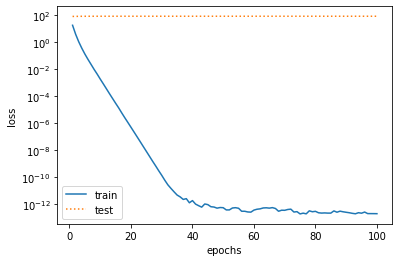

In [50]:
fit_and_plot_pytorch(0)

L2 norm of w: 0.05346333235502243


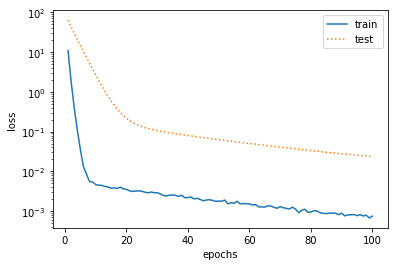

In [51]:
fit_and_plot_pytorch(3)

# 丢弃法

## 从零开始实现

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import sys


In [2]:
def dropout(X,drop_prob):
    X=X.float()
    assert 0<=drop_prob<=1
    keep_prob=1-drop_prob
    if keep_prob==0:
        return torch.zeros_like(X)
    mask=(torch.randn(X.shape)<keep_prob).float()
    return mask*X/keep_prob

In [65]:
X=torch.arange(16).view(2,8)

In [66]:
dropout(X,0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [67]:
dropout(X,0.5)

tensor([[ 0.,  2.,  4.,  6.,  0., 10.,  0.,  0.],
        [16., 18., 20.,  0., 24., 26., 28., 30.]])

In [68]:
dropout(X,1.0)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

### 定义模型参数

In [3]:
num_inputs,num_outputs,num_hiddens1,num_hiddens2=784,10,256,256

W1=torch.tensor(np.random.normal(0,0.01,size=(num_inputs,num_hiddens1)),dtype=torch.float,requires_grad=True)
b1=torch.zeros(num_hiddens1,requires_grad=True)
W2=torch.tensor(np.random.normal(0,0.01,size=(num_hiddens1,num_hiddens2)),dtype=torch.float,requires_grad=True)
b2=torch.zeros(num_hiddens2,requires_grad=True)
W3=torch.tensor(np.random.normal(0,0.01,size=(num_hiddens2,num_outputs)),dtype=torch.float,requires_grad=True)
b3=torch.zeros(num_outputs,requires_grad=True)

params=[W1,b1,W2,b2,W3,b3]

### 定义模型

In [4]:
drop_prob1,drop_prob2=0.2,0.5

def net(X,is_training=True):
    X=X.view(-1,num_inputs)
    H1=(torch.matmul(X,W1)+b1).relu()
    if is_training:#只在训练模型时使用丢弃法
        H1=dropout(H1,drop_prob1)
    H2=(torch.matmul(H1,W2)+b2).relu()
    if is_training:
        H2=dropout(H2,drop_prob2)
    return torch.matmul(H2,W3)+b3

### 模型评估

In [5]:
def evaluate_accuracy(data_iter,net):
    acc_sum,n=0.0,0
    for X,y in data_iter:
        if isinstance(net,torch.nn.Module):
            net.eval()#评估模式，这会关闭dropout
            acc_sum+=(net(X).argmax(dim=1)==y).float().sum().item()
            net.train()#改回训练模式
        else:
            if('is_training' in net.__code__.co_varnames):#如果有is_training这个参数
                #将is_training设置为False
                acc_sum+=(net(X,is_training=False).argmax(dim=1)==y).float().sum().item()
        n+=y.shape[0]
    return acc_sum/n

### 准备数据集

In [6]:
batch_size=256
mnist_train=torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST',train=True,download=False,transform=transforms.ToTensor())
mnist_test=torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST',train=False,download=False,transform=transforms.ToTensor())
if sys.platform.startswith('win'):
    num_workers=0
else:
    num_workers=4
train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=num_workers)

### 定义优化算法

In [7]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data-=lr*param.grad/batch_size

### 训练和测试模型

In [8]:
def train_ch3(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            y_hat=net(X)
            l=loss(y_hat,y).sum()
            
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
                    
            l.backward()
            if optimizer is None:
                sgd(params,lr,batch_size)
            else:
                optimizer.step()
                
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        
        test_acc=evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))

In [9]:
num_epochs,lr,batch_size=5,100.0,256
loss=torch.nn.CrossEntropyLoss()

In [10]:
train_ch3(net,train_iter,test_iter,loss,num_epochs,batch_size,params,lr)

epoch 1,loss 0.0045,train acc 0.563,test acc 0.684
epoch 2,loss 0.0022,train acc 0.788,test acc 0.816
epoch 3,loss 0.0019,train acc 0.824,test acc 0.817
epoch 4,loss 0.0017,train acc 0.840,test acc 0.738
epoch 5,loss 0.0016,train acc 0.849,test acc 0.836


## 简洁实现

In [11]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

In [12]:
net=nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs,num_hiddens1),
    nn.ReLU(),
    nn.Dropout(drop_prob1),
    nn.Linear(num_hiddens1,num_hiddens2),
    nn.ReLU(),
    nn.Dropout(drop_prob2),
    nn.Linear(num_hiddens2,10)
)

for param in net.parameters():
    nn.init.normal_(param,mean=0,std=0.01)

In [13]:
optimizer=torch.optim.SGD(net.parameters(),lr=0.5)
train_ch3(net,train_iter,test_iter,loss,num_epochs,batch_size,None,None,optimizer)

epoch 1,loss 0.0043,train acc 0.574,test acc 0.703
epoch 2,loss 0.0024,train acc 0.773,test acc 0.779
epoch 3,loss 0.0019,train acc 0.823,test acc 0.838
epoch 4,loss 0.0017,train acc 0.840,test acc 0.820
epoch 5,loss 0.0016,train acc 0.851,test acc 0.835
